In [7]:
import numpy as np
import torch
torch.inf = np.inf

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import mean_squared_error as mse

from data import parallel_line, orthogonal, triangle, lines_3D, real_data_loader, add_noise_data
from models import Autoencoder, VAE
from train2 import train_AE, train_TAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch")

from base import *

cuda:0


In [3]:
X, Y, X_noise, n_clusters = parallel_line(noise=0.1)
shapes(X,Y,X_noise)

shuffle_idx = torch.randperm(X.shape[0])
X = X[shuffle_idx].float().to(device)
Y = Y[shuffle_idx].float()

# color= ['red' if l == 0 else 'blue' if l == 1 else 'green' for l in Y.cpu().detach().numpy()]
# plt.figure(figsize=(7,7));plt.axis('off')
# plt.scatter(X_noise[:,0], X_noise[:,1], color=color)
# plt.show()

X        : torch.Size([150, 5])
Y        : torch.Size([150])
X_noise  : torch.Size([150, 5])


In [4]:
X_ = X.clone()
for samp in X_:
    if np.random.rand() > 0.5:
        idx = np.random.randint(0,5,size=2)
        samp[idx] = 0

In [8]:
# Clustering directly
k = KMeans(n_clusters=n_clusters, random_state=0).fit(X.cpu().numpy()).labels_
k_loss = adjusted_rand_score(k, Y)
print(f"Direct kmeans: {k_loss:.4f}")

# Standard AE
autoencoder = Autoencoder(X.shape[1], embed=2)
losses = train_AE(autoencoder, X=X_.clone(), X_out=X.clone(), epochs=100, verbose=1, lr=0.001)

embed_x = autoencoder.enc1(X_).cpu().detach().numpy()
kmeans = KMeans(n_clusters).fit(embed_x).labels_
kmeans_loss = adjusted_rand_score(kmeans, Y)
print(f"Kmeans after AE: {kmeans_loss:.4f}")

tae, losses, clust_assign, centers = train_TAE(X=X_.clone(), X_out=X.clone(), n_clusters=n_clusters, reg=0.1, lr=0.1, embed=2, epochs=50, verbose=1)
TAE_ari = adjusted_rand_score(clust_assign.cpu().numpy(), Y)
print(f"Kmeans after TAE: {TAE_ari:.4f}")

Direct kmeans: 0.2656


Epoch: 100|100: 100%|███████| 100/100 [00:27<00:00,  3.69it/s, loss 1.0096]


Kmeans after AE: 0.3243
Kmeans after TAE: 0.8955


In [12]:
recon = autoencoder(X_).cpu().detach().numpy()
recon_mse = mse(recon, X.cpu().numpy())
print(f"AE reconstruction MSE  = {recon_mse:.4f}")

taepred = np.zeros(X.shape)
for i in range(len(X)):
    ass = clust_assign[i]
    taepred[i] = (tae.AE[ass](X_[i] - centers[ass]) + centers[ass]).cpu().detach().numpy().squeeze()

recon_mse_tae = mse(taepred, X.cpu().numpy())
print(f"TAE reconstruction MSE = {recon_mse_tae:.4f}")

AE reconstruction MSE  = 1.0041
TAE reconstruction MSE = 0.4397


# Real data

In [4]:
X, Y = real_data_loader(dataset='penguin4', class_labels_list=[0,1,2], normalise_data=True, subsample=False,)
# X = X / 255.

shapes(X, Y)

X  : torch.Size([334, 4])
Y  : torch.Size([334])


In [5]:
n_clusters = 5
embed = 1
reg = 0.1
epochs = 50

X = X.to(device)

# Clustering directly
k = KMeans(n_clusters=n_clusters, random_state=0).fit(X.cpu().numpy()).labels_
k_loss = adjusted_rand_score(k, Y)
print(f"Direct kmeans: {k_loss:.4f}")

# Standard AE
autoencoder = Autoencoder(X.shape[1], embed=embed)
losses = train_AE(autoencoder, X.clone(), epochs=epochs, verbose=1)

embed_x = autoencoder.enc1(X).cpu().detach().numpy()
kmeans = KMeans(n_clusters).fit(embed_x).labels_
kmeans_loss = adjusted_rand_score(kmeans, Y)
print(f"Kmeans after AE: {kmeans_loss:.4f}")

# TAE
clust_assign = train_TAE(X.clone(), n_clusters=n_clusters, reg=reg, embed=embed, epochs=epochs, verbose=1)[2]
TAE_ari = adjusted_rand_score(torch.argmax(clust_assign, axis=0).cpu().detach().numpy(), Y)
print(f"Kmeans after TAE: {TAE_ari:.4f}")

Direct kmeans: 0.5581


Epoch: 50|50: 100%|███████████| 50/50 [00:24<00:00,  2.00it/s, loss 0.0144]


Kmeans after AE: 0.1458


Epoch: 50|50: 100%|███████████| 50/50 [02:12<00:00,  2.66s/it, loss 0.0006]

Kmeans after TAE: 0.5528


In [43]:
autoencoder = Autoencoder(in_feature=X.shape[1],embed=2,linear=True).to(device)
train_loss = train_AE(autoencoder, X.float(), lr=0.001, epochs=50, CNN=False, verbose=1)

100%|██████████| 50/50 [00:42<00:00,  1.19it/s]

epoch  49  loss  0.010619167005643249


In [ ]:
X_embed = net.enc1(X.float().to(device)).cpu().detach().numpy()
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_embed)
adjusted_rand_score(kmeans.labels_, Y.cpu().detach().numpy())

In [ ]:
TAE, train_loss, clust_assign, X_, X_out = train_TAE(X, n_clusters=5, reg=0.1, embed=169, epochs=50, verbose=1)

In [45]:
adjusted_rand_score(torch.argmax(clust_assign,axis=0).cpu().detach().numpy(), Y_.cpu().detach().numpy())

0.629550581111624

Kmeans after AE 0.41625843086495257
X_embed  : (1000, 169)
X_recon  : (1000, 784)


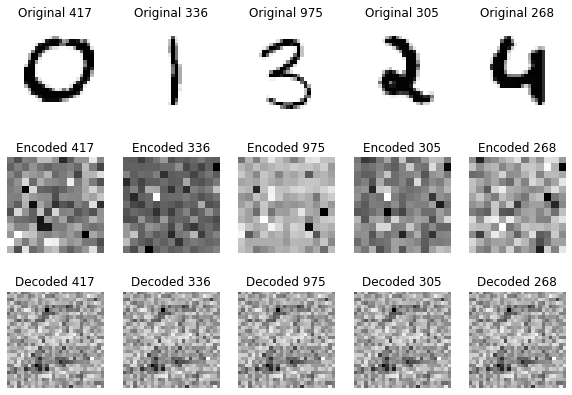

In [29]:
# VISUALIZE MNIST EMBEDDING

X_embed = autoencoder.enc1(X.float().to(device)).cpu().detach().numpy()
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_embed).labels_
print("Kmeans after AE", adjusted_rand_score(kmeans, Y))

X_recon = autoencoder.dec1(torch.tensor(X_embed).float().to(device)).cpu().detach().numpy()
shapes(X_embed,X_recon)

axes = plt.subplots(3,5,figsize=(10,7))[1]
samples = np.random.choice(np.arange(len(X)),size=5)
axes_off(axes)

for i in range(5):
    s = samples[i]
    axes[0,i].set_title(f"Original {s}")
    axes[0,i].imshow(X[s].cpu().reshape(28,28),cmap=plt.cm.Greys)
    axes[1,i].set_title(f"Encoded {s}")
    axes[1,i].imshow(X_embed[s].reshape(13,13),cmap=plt.cm.Greys)
    axes[2,i].set_title(f"Decoded {s}")
    axes[2,i].imshow(X_recon[s].reshape(28,28),cmap=plt.cm.Greys)